# Measurement Data and Foresight - Week 11 Practical
In this series of practicals, you'll learn how to analyse time series data using data science methodology starting from problem formulation to storytelling with data.

<b>Week 11 Objectives</b>
At the end of this practical, you will be able to:

 - Efficiently formulate forecasting problems in time series domain using design thinking approach
 - Load and handle time series data using Python.
 - Indentify the patterns (e.g. trends, cycles and seasonality) in timeseries data.

<b>Table of Contents</b>

1. Problem Formulation
2. Data Collection and preprocessing
3. Data preparation
4. Visualisation and exploratory analysis

# 1. Problem Formulation

Formulating the problem, requires the carefull understanding of how the time series forecasting results will be used, who needs this forecast, and how advance it is required (several years in advance or few minutes before hand). It is a common task in many business, where it helps to make inform decisions. For example to schedule staff in a call centre next week, it requires forecasts of call volumes.

In this notebook, you'll follow the above data science process to analyse time series data.

|<center>Exercise</center>|
| ---- |
| What is time series data? Give an example of time series data. |

In [1]:
# write your answer here

For this practical, we will work on the following  scenario.

Monash University, in Melbourne, Australia wants to take part in fighting against climate change. They want renuable energy, generated using the wind and solar to be more reliable and affordable. But the challenge is renuable energy does not always be produced when the demand for electricity is higher. It depends mainly on the weather conditions. Monash has set up a microgrid with rooftop solar installations and a battery for energy storage. They need to implement a optimal schedule for charging and discharging these batteries. In this way, they can charge the battery with over production of solar energy, and use power from the battery instead of using from the grid, when electricity price is higher, and also schedule the demand for electricity based on the energy availability. They need to know the energy demand for the building and energy production from the solar in order to implement optimal schedule for the battery.


|<center>Exercise</center>|
| ---- |
| <center> 1. What kind of time series analysis is this? </center> |
|<center> 2. Who are my stakeholders? </center> |
| 3. What value does this bring to the stakeholders? |

In [2]:
# write your answer here

# 2. Data Collection and preprocessing

The next step in data science process is to collect the appropriate data for the analysis. It might be a challenging step, as in real life scenario, data for time series often needs the accumulated expertise of the people who manages these data and will utilize the forecasting results. 

## 2.1 Collection

Monash University has provided the data with historical 15-minutely energy demand of 6 buildings and 15-minutely prower production of 6 solar panels. Data can be accessed from the 2021 IEEE-CIS technical chanllenge on renewable energy prediction at https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling#files. 

For this Prac, we will use the Building1 timeseries of energy demand. To get this data, first go to the site and download the file phase_1_data.zip, and unpack it. Note that orginal timestamp is provided in UTC format and universal time. 

We will also use some weather data (same as the lectorial), which is provided for you in 'weather_combi.txt'.

## 2.2 Data preprocessing

Before we can do any analysis, we need to get the data into an appropriate form. The unzipped data file 'phase_1_data.tsf' contains building energy from the Monash University Microgrid competition.  However, it is in an unusual  '.tsf'  format, which requires some preporcessing to extract the building 1 timeseries data.

### 2.2.1 Preprocessing and extracting the Building1 series
Before we can do any analysis, we need to get the data into an appropriate form. The data file 'phase_1_data.tsf' contains building energy from the Monash University Microgrid competition, including for building 1 (which we want).  However, it is in an unusual '.tsf' format, which requires some preporcessing to extract the building 1 timeseries data.

The code below is taken from https://github.com/rakshitha123/TSForecasting/blob/master/utils/data_loader.py and is part of repository associated with the following publication:
-  Monash Time Series Forecasting Archive, Godahewa, Rakshitha and Bergmeir, Christoph and Webb, Geoffrey I. and Hyndman, Rob J. and Montero-Manso, Pablo, Neural Information Processing Systems Track on Datasets and Benchmarks, 2021.

In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd

# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
# loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

# print(loaded_data)
# print(frequency)
# print(forecast_horizon)
# print(contain_missing_values)
# print(contain_equal_length)

In [2]:
loaded_data, freq, fcst_horizon, missing_values, equal_length = convert_tsf_to_dataframe("data/phase_1_data.tsf")
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


You can see that the code has nested values for many series, but we want only the Building 1 series. So lets extract that. 

First of all, we have the start timestmap for the series, but not a full index. Let's calculate an index for our series.

In [3]:
print(len(loaded_data['series_value'][1]))

60483


In [4]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%Y-%m-%d %H:%M:00 ') for dt in 
       datetime_range(datetime(2019, 1, 9, 23,15), datetime(2020, 10, 1, 00,00), 
                      timedelta(minutes=15))]

In [5]:
len(dts)

60483

In [6]:
dts[-1]

'2020-09-30 23:45:00 '

Next we construct a dataframe to hold our series values:

In [7]:
df = pd.DataFrame(loaded_data['series_value'][1],columns = ['energy_demand'])
df

,energy_demand
0,8.1
1,15.7
2,22.8
3,32.7
4,8.1
...,...
60478,14.4
60479,18.8
60480,4.5
60481,9.6


We add the time index:

In [8]:
df['Datetime'] = dts
df = df.set_index(['Datetime'])

In [9]:
df.head(5)

,energy_demand
Datetime,
2019-01-09 23:15:00,8.1
2019-01-09 23:30:00,15.7
2019-01-09 23:45:00,22.8
2019-01-10 00:00:00,32.7
2019-01-10 00:15:00,8.1


Export our processed data to a csv file for safe keeping:

In [10]:
df.to_csv("data/Building1.csv")

Check that the folder /data contains the file Building1.csv, and the clear the workspace of the dataframe

In [11]:
del df

## 2.3 Load the data into dataframe 
Starting afresh, load the Building1 series into a pandas dataframe

In [10]:
# import pandas library using alias pd
import pandas as pd

#load the data
bdf = pd.read_csv('data/Building1.csv')

# Display first five rows of the data
bdf.head(5)

,Datetime,energy_demand
0,2019-01-09 23:15:00,8.1
1,2019-01-09 23:30:00,15.7
2,2019-01-09 23:45:00,22.8
3,2019-01-10 00:00:00,32.7
4,2019-01-10 00:15:00,8.1


Then do the same for the weather data series

In [11]:
wdf = pd.read_csv('data/weather_combi.txt',delimiter=',')

# view columns in the weather data
wdf.columns

Index(['datetime', 'max_temp_moorabbin', 'max_temp_olympic',
       'min_temp_moorabbin', 'min_temp_olympic', 'rainfall_moorabbin',
       'rainfall_oakleigh', 'rainfall_olympic', 'solar_moorabbin',
       'solar_oakleigh', 'solar_olympic', 'temperature (degC)',
       'dewpoint_temperature (degC)', 'wind_speed (m/s)',
       'mean_sea_level_pressure (Pa)', 'relative_humidity ((0-1))',
       'surface_solar_radiation (W/m^2)', 'surface_thermal_radiation (W/m^2)',
       'total_cloud_cover (0-1)'],
      dtype='object')

Keep just the temperature data, drop the rest:

In [12]:
wdf = wdf[['datetime','temperature (degC)']]
wdf.columns

Index(['datetime', 'temperature (degC)'], dtype='object')

In [13]:
wdf

,datetime,temperature (degC)
0,2016-01-01 00:00:00,24.84
1,2016-01-01 00:15:00,24.84
2,2016-01-01 00:30:00,25.70
3,2016-01-01 00:45:00,25.70
4,2016-01-01 01:00:00,25.70
...,...,...
189884,2021-05-31 23:00:00,9.83
189885,2021-05-31 23:15:00,9.83
189886,2021-05-31 23:30:00,10.73
189887,2021-05-31 23:45:00,10.73


# 3. Data Preparation
We have two separate timeseries in different dataframes, df and wdf, and we want to merge them before undertaking any analysis. The final dataframe that we want has the following characteristics:

<b>Column description</b>

1. <b> Datetime </b> : Timestamp for the series
2. <b> Building1 </b> : Energy demand for the building
3. <b> temperature (degC)  </b> : temperature recoreded in degree celsius.

## 3.1 Time series Indexing

In timeseries, the data is the value observed or measured at a particular time period. To properly analysing the timeseries data, it is essential that the datetime values are used as the index for the merged dataframe.

Looking at the DateTimeIndex valul for the Building1 series below, the timeseries starts from "2019-01-09 23:15:00" and values are provided util "2020-09-30 23:45:00" (last day of 2020-sep).

In [14]:
# Look at dataframe information
bdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60483 entries, 0 to 60482
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datetime       60483 non-null  object 
 1   energy_demand  60395 non-null  float64
dtypes: float64(1), object(1)
memory usage: 945.2+ KB


In [15]:
# set index for the dataframe
bdf = bdf.set_index(['Datetime'])
wdf = wdf.set_index(['datetime'])

In [16]:
# modify Datetime index datatype from 'object' to 'datatime64[ns]'
bdf.index = bdf.index.astype('datetime64[ns]')
wdf.index = wdf.index.astype('datetime64[ns]')
bdf.index

DatetimeIndex(['2019-01-09 23:15:00', '2019-01-09 23:30:00',
               '2019-01-09 23:45:00', '2019-01-10 00:00:00',
               '2019-01-10 00:15:00', '2019-01-10 00:30:00',
               '2019-01-10 00:45:00', '2019-01-10 01:00:00',
               '2019-01-10 01:15:00', '2019-01-10 01:30:00',
               ...
               '2020-09-30 21:30:00', '2020-09-30 21:45:00',
               '2020-09-30 22:00:00', '2020-09-30 22:15:00',
               '2020-09-30 22:30:00', '2020-09-30 22:45:00',
               '2020-09-30 23:00:00', '2020-09-30 23:15:00',
               '2020-09-30 23:30:00', '2020-09-30 23:45:00'],
              dtype='datetime64[ns]', name='Datetime', length=60483, freq=None)

## 3.2 TimeZone convertion

To visualise timeseries, it is nessesary to convert the datetimeindex into the right timezone format. This time series has the AEDT time zone (Australian Eastern Daylight Time). The 'pytz' package (https://pypi.org/project/pytz/) in python provides an easy way to deal with the different timezones. 

First, modify datetime into the local UTC (Coordinated Universal Time) format using tz_localize() function. From UTC format, Melbourne has either 10 hours or 11 hours offset from UCT based on daylight saving period (https://www.timeanddate.com/time/zone/australia/melbourne). We use the tz_convert() function to convert it into the right timezone.

After conversion, DateTimeIndex series starts from '2019-01-10 10:15' and ends to '2020-10-01 09:45' (First day of 2020-oct).

In [17]:
# import the package
import pytz

# Convert DateTimeIndex into 'Australia/Melbourne' timezone.
bdf.index = bdf.index.tz_localize('UTC').tz_convert('Australia/Melbourne')
wdf.index = wdf.index.tz_localize('UTC').tz_convert('Australia/Melbourne')

bdf.index

DatetimeIndex(['2019-01-10 10:15:00+11:00', '2019-01-10 10:30:00+11:00',
               '2019-01-10 10:45:00+11:00', '2019-01-10 11:00:00+11:00',
               '2019-01-10 11:15:00+11:00', '2019-01-10 11:30:00+11:00',
               '2019-01-10 11:45:00+11:00', '2019-01-10 12:00:00+11:00',
               '2019-01-10 12:15:00+11:00', '2019-01-10 12:30:00+11:00',
               ...
               '2020-10-01 07:30:00+10:00', '2020-10-01 07:45:00+10:00',
               '2020-10-01 08:00:00+10:00', '2020-10-01 08:15:00+10:00',
               '2020-10-01 08:30:00+10:00', '2020-10-01 08:45:00+10:00',
               '2020-10-01 09:00:00+10:00', '2020-10-01 09:15:00+10:00',
               '2020-10-01 09:30:00+10:00', '2020-10-01 09:45:00+10:00'],
              dtype='datetime64[ns, Australia/Melbourne]', name='Datetime', length=60483, freq=None)

In [18]:
wdf.index

DatetimeIndex(['2016-01-01 11:00:00+11:00', '2016-01-01 11:15:00+11:00',
               '2016-01-01 11:30:00+11:00', '2016-01-01 11:45:00+11:00',
               '2016-01-01 12:00:00+11:00', '2016-01-01 12:15:00+11:00',
               '2016-01-01 12:30:00+11:00', '2016-01-01 12:45:00+11:00',
               '2016-01-01 13:00:00+11:00', '2016-01-01 13:15:00+11:00',
               ...
               '2021-06-01 07:45:00+10:00', '2021-06-01 08:00:00+10:00',
               '2021-06-01 08:15:00+10:00', '2021-06-01 08:30:00+10:00',
               '2021-06-01 08:45:00+10:00', '2021-06-01 09:00:00+10:00',
               '2021-06-01 09:15:00+10:00', '2021-06-01 09:30:00+10:00',
               '2021-06-01 09:45:00+10:00', '2021-06-01 10:00:00+10:00'],
              dtype='datetime64[ns, Australia/Melbourne]', name='datetime', length=189889, freq=None)

Now that we have a consistent index for the two dataframes, we can join them:

In [19]:
# join both df and wdf
df = bdf.join(wdf)

In [20]:
df

,energy_demand,temperature (degC)
Datetime,,
2019-01-10 10:15:00+11:00,8.1,17.44
2019-01-10 10:30:00+11:00,15.7,18.90
2019-01-10 10:45:00+11:00,22.8,18.90
2019-01-10 11:00:00+11:00,32.7,18.90
2019-01-10 11:15:00+11:00,8.1,18.90
...,...,...
2020-10-01 08:45:00+10:00,14.4,12.06
2020-10-01 09:00:00+10:00,18.8,12.06
2020-10-01 09:15:00+10:00,4.5,12.06


 ## 3.3 Slicing
For this analysis, we use data from 2020 year and indexing help us to slice the series for a particular timeframe.

<AxesSubplot:xlabel='Datetime'>

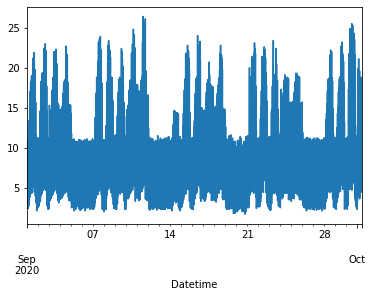

In [21]:
# slicing to view data for a particular initerval
df['2020-09-01':'2020-10-01']['energy_demand'].plot()

<b> Missing values  </b>

|<center>Exercise</center>|
| ---- |
| <center>By this time, you must have understood, why we should handle missinig data from the course videos. Mention some of the reason for missing valules in the time series and what are the ways to handle it.</center>|

In [22]:
print("Total number of null/missing values:", df['energy_demand'].isna().sum())
print("Number of null/missing values in year 2020:", df['2020']['energy_demand'].isna().sum())

Total number of null/missing values: 88
Number of null/missing values in year 2020: 23


/tmp/ipykernel_706932/1360559198.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print("Number of null/missing values in year 2020:", df['2020']['energy_demand'].isna().sum())


In [23]:
import numpy as np

# to look at the timestamps which has missing values
s = pd.isnull(df['2020']['energy_demand'])
missing_index = df['2020']['energy_demand'][s]
print("index of missinig values:" ,np.array(missing_index.index) )

index of missinig values: [Timestamp('2020-01-10 16:15:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-01-10 16:30:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 08:00:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 08:15:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 08:30:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 08:45:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 09:00:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 09:15:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 09:30:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 09:45:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 10:00:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 10:15:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 10:30:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 10:45:00+1100', tz='Australia/Melbourne')
 Timestamp('2020-03-29 11:00:00+1100', tz='Australia/Melbourne')

/tmp/ipykernel_706932/1681611818.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  s = pd.isnull(df['2020']['energy_demand'])
/tmp/ipykernel_706932/1681611818.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  missing_index = df['2020']['energy_demand'][s]


We observe major 5 hours of missing values on date 2020-3-29. 

Since this energy demand time series is non-linear,we use interpolate() with method polynomial of order 2.


|<center>Exercise</center>|
| ---- |
|<center> Modify belolw code for different order in polynomial method or use linear method to verify, how each method fills the missing values.</center>|

/tmp/ipykernel_706932/3652228262.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df2 = df['2020']


<AxesSubplot:xlabel='Datetime'>

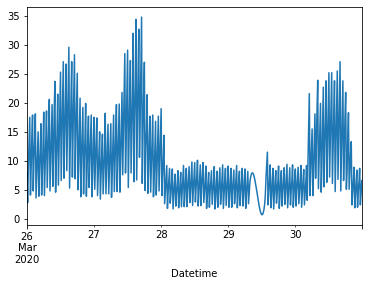

In [24]:
# df['2020-3-26':'2020-03-30']['energy_demand'].plot()

# Using non-linear initerpolation to fill the missing values.
df2 = df['2020']
df2 = df2.interpolate(method="polynomial", order =3)
df2['2020-3-26':'2020-03-30']['energy_demand'].plot()


In [25]:
df2.isna().sum()

energy_demand         0
temperature (degC)    0
dtype: int64

# 4 Visualisation and exploratory analysis

Looking at the time series plot, help us in understanding the overall nature  of the data and to indentify outliers or any abnormal points. To look at month,weekly, daily patterns DateTimeIndex provides easier functionality.



In [26]:
# Using Datetime index to get the month,hour and day of the week
# assigning it to the new column in the dataframe df2, so that we can use it to visualise different trend cycle or seasonality
df2['month']=df2.index.month_name()
df2['hour'] = df2.index.hour
df2['day_of_week']  = df2.index.day_name()

Text(0.5, 0, 'Date')

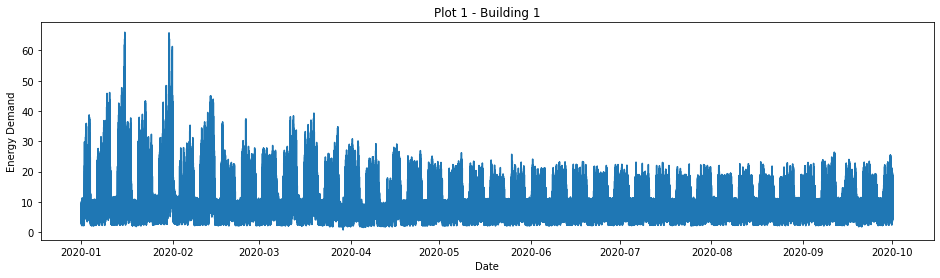

In [27]:
# import matplotlib and seaborn packages for using different plot and aligning them.
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting all the data for year 2020. plot() uses line as a default
plt.figure(figsize=(16,4))
plt.plot(df2['energy_demand'])
plt.title('Plot 1 - Building 1')
plt.ylabel('Energy Demand')
plt.xlabel('Date')

|<center>Exercise</center>|
| ---- |
|<center>What patterns can you see in this plot?</center>|

In [30]:
# write your answers here

Text(0, 0.5, 'Energy Demand')

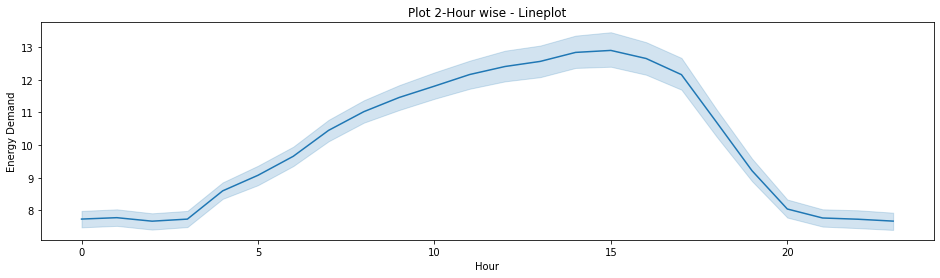

In [28]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=df2, x='hour', y=df2['energy_demand'], ax=axes[0,0])
axes[0,0].set_title("Plot 2-Hour wise - Lineplot")
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Energy Demand')

Text(0, 0.5, 'Energy Demand')

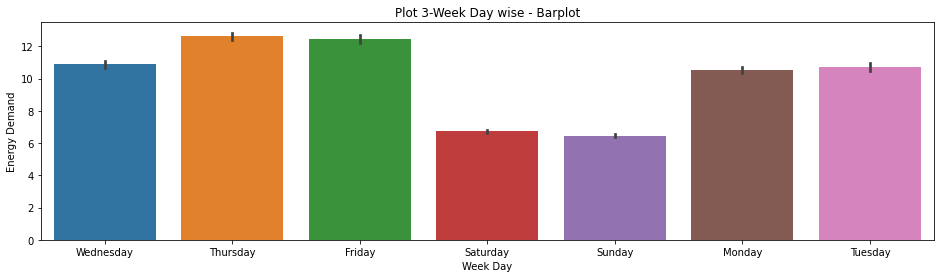

In [29]:
# Barplot to view 2020 weekly energy demand 
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.barplot(data=df2, x='day_of_week', y=df2['energy_demand'],ax=axes[0,0])
axes[0,0].set_title("Plot 3-Week Day wise - Barplot")
axes[0,0].set_xlabel('Week Day')
axes[0,0].set_ylabel('Energy Demand')

Text(0, 0.5, 'Energy Demand')

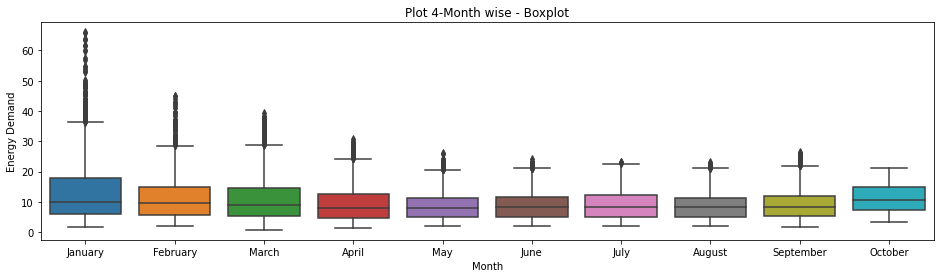

In [30]:
# Boxplot to view 2020 monthly energy demand 
fig, ax = plt.subplots(figsize=(16,4))
sns.boxplot(data=df2, x='month', y=df2['energy_demand'], ax = ax)
ax.set_title("Plot 4-Month wise - Boxplot")
ax.set_xlabel('Month')
ax.set_ylabel('Energy Demand')

<b>Observation from Time series plot: </b>

1. Plot 1 - Shows the entier energy demand timeseries for the whole year 2020, from Jan to Sep and for the Oct month we have until '2020-10-01 09:45' due to daylight saving timezone conversion.
2. Plot 2 - Hour-wise plot, shows the daily trend-cycle, energy demand has increasing trend from 4 (early morning), reaches peak at 15 (3PM afternoon) and then follows the decreasing trend (off-working hours).
3. Plot 3 - Week wise plot,  durring working days energy demand increasing from monday, reaches peak on thursday and reduces on friday. On weekend,  energy demand is very less.
4. Plot 4 - Since we have used only 2020 year data, month-wise plot shows the trend similar to overall data. Energy demand has reduced from feb, due to lockdown and covid restrictions.

<b> Outliers: </b>

We do observe some outliers in the plot 4-boxplot. If we observe any particular outlier very far extreme or unusual energy demand with no proper reasons (or due to some malfunctioning), we drop these observation and treat them as missing value. 

Here outliers seen in the boxplot are all below 70 and possible reason are energy demand reaching peak durring summer (heavy in Jan and Feb month).

|<center>Exercise</center>|
| ---- |
|<center>What other plots could you use to explore the data?</center>|